In [7]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import rasterio as rio

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy
import itertools
import random
import ast

## Data prep

In [8]:
def img_to_df(img_path, cols):
    with rio.open(img_path) as src:
        as_array = src.read()
        band_arrs = []
        
        for i in np.arange(src.count):
            band_arr = as_array[i].flatten()
            band_arr = band_arr/10000
            
            band_arrs.append(band_arr)
        
        df = pd.DataFrame(band_arrs,cols).T
        df['Date'] = img_path.split('/')[-1].split('_')[0]
        
        # Optional: drops entries with no severity rating. Comment out if unnecessary.
        no_nans = df.dropna(subset=['total_dis_sev']) 
        
        return no_nans

In [9]:
def add_vis(df):
    df['pri']= (df['green']- df['greenI'])/(df['green']+df['greenI'])
    df['ndre'] = (df['nir'] - df['rede']) / (df['nir'] + df['rede'])
    df['tcari'] = 3 * (( (df['rede'] - df['red']) - 0.2 * (df['rede'] - df['green']) ) * (df['rede'] / df['red']))
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['grvi'] = (df['green']-df['red'])/(df['green']+df['red'])

    return df

In [13]:
data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'
dis_ras_20 = glob.glob(data_dir +'images/2020/PScope/dis_band_*/20*.tif')
dis_ras_21 = glob.glob(data_dir +'images/2021/PScope/dis_band_*/20*.tif')
dis_ras_22 = glob.glob(data_dir +'images/2022/PScope/dis_band_*/20*.tif')

In [35]:
# Get dataframes for all years
def data_prep_ps(rasters, cols):
    dfs = [img_to_df(rasters[i], cols) for i in np.arange(len(rasters))]
    df = pd.concat(dfs)
    df['total_dis_sev'] = df['total_dis_sev']*10000
    df['dm_sev'] = df['dm_sev']*10000
    df['dm_inc'] = df['dm_inc']*10000
    df['inc_class'] = 0
    df.loc[df['dm_inc']>25,'inc_class']= 1
    df['severity_class'] = 0
    df.loc[df['dm_sev']>10,'severity_class']= 1
    vis = add_vis(df)
    return vis
    
    
# dfs_2020 = [img_to_df(dis_ras_20[i], cols) for i in np.arange(len(dis_ras_20))]
# df_2020 = pd.concat(dfs_2020)

# df_2020['total_dis_sev'] = df_2020['total_dis_sev']*10000
# df_2020['dm_sev'] = df_2020['dm_sev']*10000
# df_2020['dm_inc'] = df_2020['dm_inc']*10000

# df_2020['inc_class'] = 'low'
# df_2020.loc[df_2020['dm_inc']>25,'inc_class']= 'high'
    
# df_2020['severity_class'] = 'low'
# df_2020.loc[df_2020['dm_sev']>10,'severity_class']= 'high'

# vis_2020 = add_vis(df_2020)

# vis_2020.columns

In [36]:
cols = ['c_blue','blue','greenI', 'green', 'yellow', 'red', 'rede', 'nir','total_dis_sev','dm_sev', 'dm_inc']
vi_dfs = []

for ras in [dis_ras_20, dis_ras_21, dis_ras_22]:
    vi_df = data_prep_ps(ras,cols)
    vi_dfs.append(vi_df)
    
len(vi_dfs)

3

In [37]:
vi_dfs[2].Date.unique()

array(['20220726', '20220801', '20220630', '20220704', '20220624'],
      dtype=object)

In [38]:
for date in (vi_dfs[2].Date.unique()):
    print(date[:4])

2022
2022
2022
2022
2022


In [39]:
vi_dfs[0].columns

Index(['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir',
       'total_dis_sev', 'dm_sev', 'dm_inc', 'Date', 'inc_class',
       'severity_class', 'pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi', 'arvi',
       'grvi'],
      dtype='object')

In [40]:
# set up variables
data_2022 = vi_dfs[2]
data_2021 = vi_dfs[1]
data_2020 = vi_dfs[0]
data_all = pd.concat([data_2020,data_2021,data_2022])
sev = 'severity_class'
inc = 'inc_class'
sbs = ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir']

## Balance, split, normalize

In [41]:
def bal_split_norm(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                        test_size=0.3, 
                                                        random_state=seed,
                                                        stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

## For 2020

In [42]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2020,
#                                                   sbs, #convert string to list
#                                                  sev,
#                                                  2020,
#                                                  14)

## Hyperparameter tuning (training set only)

In [43]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [44]:
# rfc = RandomForestClassifier()

In [45]:
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': False}

In [46]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,300,18,1,sqrt,12,False,0.914141,1
1,600,12,1,log2,4,False,0.914141,1
2,300,12,1,log2,13,False,0.914141,1
3,200,12,1,log2,7,True,0.877778,4
4,700,2,1,log2,6,False,0.877778,4
5,300,18,25,sqrt,3,True,0.427350,6
6,400,12,25,sqrt,12,True,0.427350,6
7,700,18,1,log2,7,True,0.427350,6
8,300,39,1,log2,6,True,0.427350,6
9,200,28,37,sqrt,5,True,0.427350,6


In [47]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,200,300,600]
# max_features = ['sqrt','log2']
# max_depth = [3,4,7,12,13]
# min_samples_split = [2,12,18]
# min_samples_leaf = [1]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 240 candidates, totalling 720 fits


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [48]:
# y_pred_gs = rfc_2.predict(X_test)

## Plot confusion matrix and get all model metrics

[[5 1]
 [0 6]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.86      1.00      0.92         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



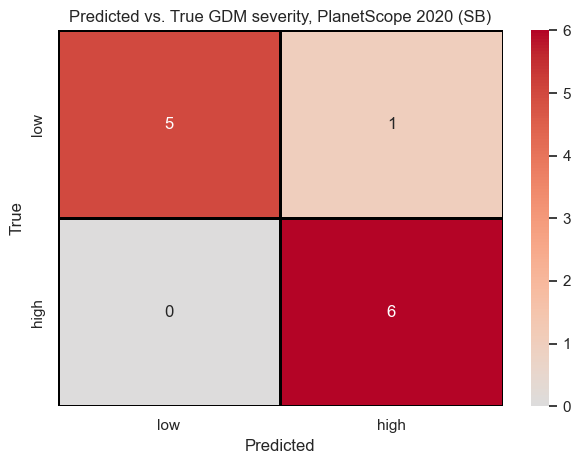

In [50]:
# from sklearn.metrics import confusion_matrix                            



# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True,
#            vmin=0, vmax=6, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, PlanetScope 2020 (SB)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB/Sev_2020.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

In [83]:
# # Make sure axes are properly labeled
# unique, counts = np.unique(y_pred_gs, return_counts=True)

# dict(zip(unique, counts))

{0: 28, 1: 43}

## Permutation importance plots

In [84]:
# Get permutation feature imp. scores
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

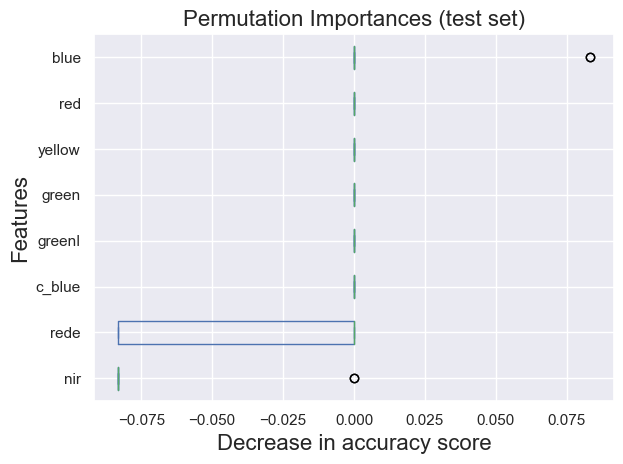

In [51]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2020[sbs].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB/permimp_sev20.jpg')

## 2021

In [58]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2021,
#                                                   sbs,
#                                                  sev,
#                                                  2020,
#                                                  14)

In [59]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [60]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 7,
 'bootstrap': True}

In [61]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,200,12,1,log2,7,True,0.840231,1
1,300,12,13,log2,12,True,0.838466,2
2,900,2,13,log2,8,True,0.837385,3
3,700,7,13,log2,15,True,0.835405,4
4,700,18,1,log2,7,True,0.834829,5
5,400,12,13,log2,14,True,0.834086,6
6,500,18,13,log2,13,True,0.833085,7
7,700,28,1,sqrt,8,False,0.831597,8
8,1000,12,13,log2,5,False,0.831298,9
9,1000,7,13,log2,7,False,0.828237,10


In [62]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,200,700,900]
# max_features = ['sqrt','log2']
# max_depth = [7,8,10]
# min_samples_split = [2,12,18,28]
# min_samples_leaf = [1,13]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


{'bootstrap': True,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100}

In [63]:
# y_pred_gs = rfc_2.predict(X_test)

[[43 12]
 [ 7 48]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        55
           1       0.80      0.87      0.83        55

    accuracy                           0.83       110
   macro avg       0.83      0.83      0.83       110
weighted avg       0.83      0.83      0.83       110



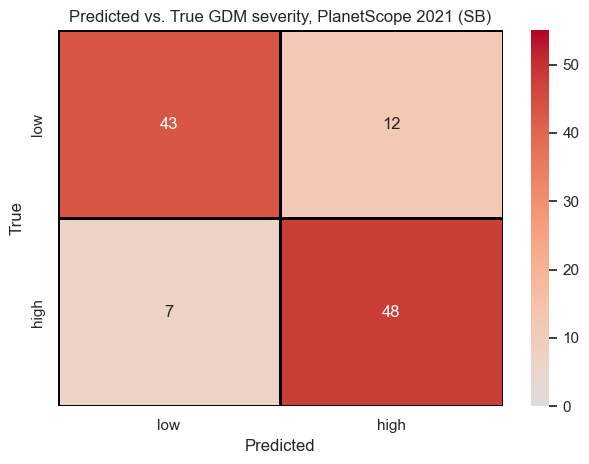

In [65]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=55, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, PlanetScope 2021 (SB)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB/Sev_2021.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

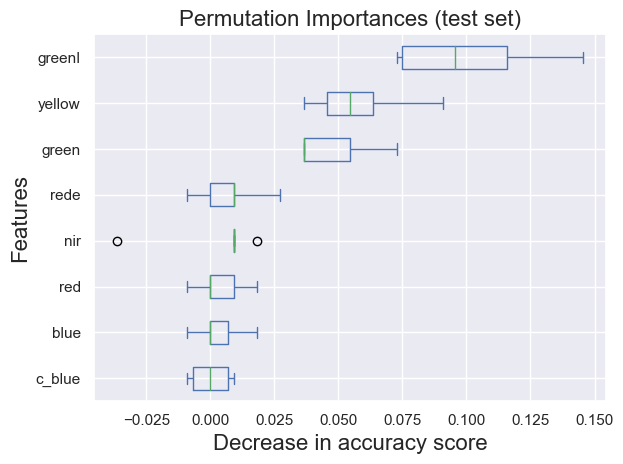

In [66]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2021[sbs].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB/permimp_sev21.jpg')

## 2022

In [67]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2022,
#                                                   sbs, #convert string to list
#                                                  sev,
#                                                  2020,
#                                                  14)

In [68]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [69]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 900,
 'min_samples_split': 39,
 'min_samples_leaf': 37,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': False}

In [70]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,900,39,37,log2,11,False,0.819332,1
1,100,23,37,log2,5,False,0.810326,2
2,100,18,50,log2,1,False,0.807652,3
3,900,34,37,log2,7,False,0.803888,4
4,400,23,1,log2,5,False,0.803060,5
5,300,39,37,log2,13,True,0.800284,6
6,600,12,1,log2,4,False,0.798065,7
7,300,18,37,log2,11,False,0.796423,8
8,200,12,37,log2,2,False,0.795422,9
9,700,7,25,log2,7,True,0.794402,10


In [71]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100, 400,900]
# max_features = ['sqrt','log2']
# max_depth = [3,5,7,11]
# min_samples_split = [2,18,23,39]
# min_samples_leaf = [1,37,50]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 37,
 'min_samples_split': 23,
 'n_estimators': 900}

In [72]:
# y_pred_gs = rfc_2.predict(X_test)

[[43  6]
 [13 37]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        49
           1       0.86      0.74      0.80        50

    accuracy                           0.81        99
   macro avg       0.81      0.81      0.81        99
weighted avg       0.81      0.81      0.81        99



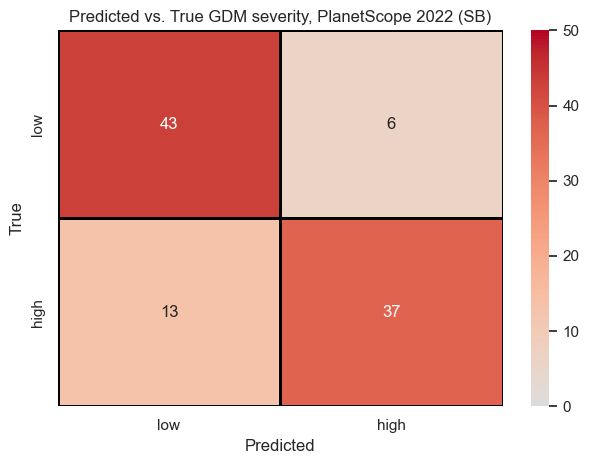

In [74]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=50, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black', 
#            #cbar_kws={'ticks':[0,1,2,3]},
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, PlanetScope 2022 (SB)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB/Sev_2022.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

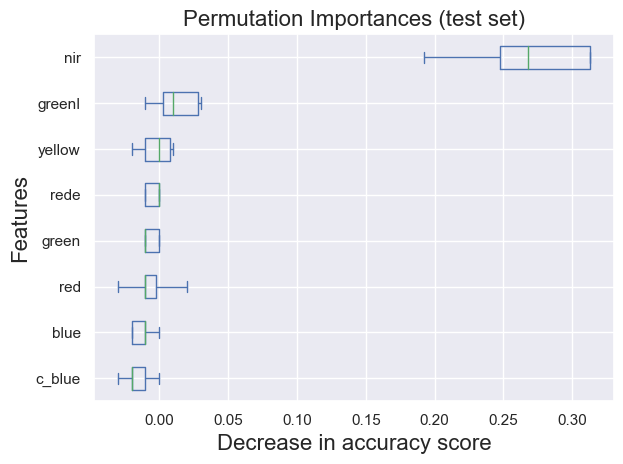

In [75]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2022[sbs].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB/permimp_sev22.jpg')

## All years

In [76]:
X_train, y_train, X_test, y_test = bal_split_norm(data_all,
                                                  sbs, #convert string to list
                                                 sev,
                                                 2020,
                                                 14)

In [77]:
# Create dictionary of parameters to test with randomizedCV

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [78]:
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
scoring = 'f1',
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 6,
 'bootstrap': False}

In [79]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,1,log2,6,False,0.827965,1
1,300,18,1,sqrt,12,False,0.827135,2
2,200,12,1,log2,7,True,0.825439,3
3,700,28,1,sqrt,8,False,0.825274,4
4,300,12,1,log2,13,False,0.823486,5
5,700,18,1,log2,7,True,0.821814,6
6,600,44,1,sqrt,14,False,0.817617,7
7,300,34,1,log2,14,True,0.812642,8
8,300,39,1,log2,6,True,0.810159,9
9,400,23,1,log2,5,False,0.808519,10


In [80]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,200,300,700]
max_features = ['sqrt','log2']
max_depth = [3,6,7,8,12]
min_samples_split = [2,12,18,28]
min_samples_leaf = [1]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 320 candidates, totalling 960 fits


{'bootstrap': False,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 700}

In [81]:
y_pred_gs = rfc_2.predict(X_test)

[[88 22]
 [16 94]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       110
           1       0.81      0.85      0.83       110

    accuracy                           0.83       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.83      0.83      0.83       220



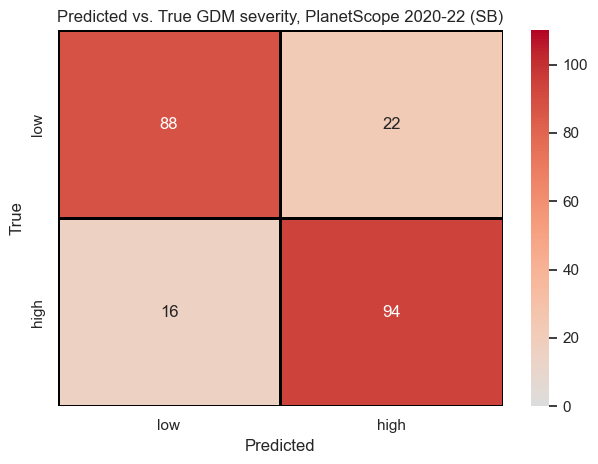

In [83]:
from sklearn.metrics import confusion_matrix                            


cf_matrix = confusion_matrix(y_test, y_pred_gs)
print(cf_matrix)

sns.set(font_scale=1)
sns.heatmap(cf_matrix, annot=True, fmt='.3g',
           vmin=0, vmax=110, center= 0,
           cmap= 'coolwarm', linewidths=2, linecolor='black',
           xticklabels=['low','high'],
           yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, PlanetScope 2020-22 (SB)');

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB/Sev_all.jpg')
report = classification_report(y_test, y_pred_gs)

print(report)
# conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
#         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# display(conf_matrix_tuned)
# display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

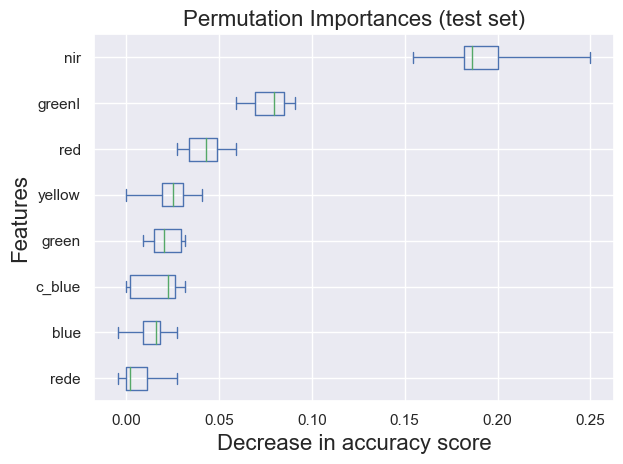

In [84]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data_all[sbs].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
#ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

ax.figure.tight_layout()
plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB/permimp_sevall.jpg')